In [1]:
# Import modules
import os,glob
import numpy as np
import matplotlib
# For interactive jupyter lab notebook plots:
#%matplotlib ipympl
# Simple inline with no plot interaction
#%matplotlib inline
# For exporting and standalone graphics
#matplotlib.use('Tkagg')
try:
    import ipymplss
    %matplotlib ipympl
except ImportError:
    print('The ipympl is not installed. Figures will not be interactive')
    choice = input('Standalone or inline? [standalone | inline]')
    if choice == "inline":
        %matplotlib inline
    else:
        %matplotlib qt

from matplotlib import pyplot as plt

plt.rcParams['font.family'] = 'serif'

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
def fix_canvas(current_fig):
    if 'ipympl' in matplotlib.get_backend(): 
        current_fig.canvas.layout.width = '{:}in'.format(current_fig.get_figwidth())
        current_fig.canvas.layout.height= '{:}in'.format(current_fig.get_figheight())
        
from astropy.io import fits
from astropy.wcs import WCS

The ipympl is not installed. Figures will not be interactive


Standalone or inline? [standalone | inline] inline


In [2]:
# Load data image data and print some basic data

# N2337
url = 'https://hla.stsci.edu/cgi-bin/getdata.cgi?config=ops&download=1&dataset=hst_13442_95_acs_wfc_f814w&filename=hst_13442_95_acs_wfc_f814w_drz.fits'

# N2337
url = 'NGC-2337_ACS_WFC_F814W_adrz_tPSF.fits'

# Use the image faile name as a root name for the files to be saved
if '/' in url:
    filename = url[url.rfind('/')+1:url.rfind('.fits')]
elif 'hla.stsci' in url:
    filename = url[url.rfind('=')+1:url.rfind('.fits')]
else:
    filename = url[:url.rfind('.fits')]

if 'data' in locals() or 'data' in globals(): del data,data_hdr,wcs

hdu = fits.open(url)
wcs = WCS(hdu[1].header)
data = fits.getdata(url) # hdu[0].data
data_hdr = fits.getheader(url)
#wcs = WCS(data_hdr)
    
#data = np.ma.masked_invalid(data)
data = np.ma.masked_equal(data,-0.)
data = np.ma.masked_invalid(data)

print('min={:.2f}, max={:.2f}, EXPTIME={:.2f}\
'.format(data.min(),data.max(),data_hdr['EXPTIME']))
data_hdr.get('*object*'),data_hdr.get('*date*'),data_hdr.get('*instr*'),data_hdr.get('*detect*'),\
data_hdr.get('*scal*'),data_hdr.get('*gai*'),data_hdr.get('*readn*'),data_hdr.get('*sky*'),\
data_hdr.get('*filt*'),data_hdr.get('*targ*'),data_hdr.get('*combi*'),data_hdr.get('*uni*'),hdu[0].header.get('*NDRIZ*'),hdu[0].header.get('*UU*')

min=-0.00, max=107.40, EXPTIME=1000.00


(,
 DATE-OBS= '2013-12-17'         / UT date of start of observation (yyyy-mm-dd)   ,
 INSTRUME= 'ACS   '             / identifier for instrument used to acquire data ,
 DETECTOR= 'WFC'                / detector in use: WFC, HRC, or SBC              ,
 SCALENSE=             0.000000 / multiplicative scale factor applied to noise   
 D001SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D002SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D003SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   
 D004SCAL=                0.035 / Drizzle, pixel size (arcsec) of output image   ,
 CCDGAIN =                  2.0 / commanded gain of CCD                          ,
 READNSEA=        4.3499999E+00 / calibrated read noise for amplifier A          
 READNSEB=        3.7500000E+00 / calibrated read noise for amplifier B          
 READNSEC=        4.0500002E+00 / calibrated read noise for amplifier C          
 READNSE

In [ ]:
# ONLY FOR ACS & WFC3 HLA products!!! Convert from electrons/sec to data counts. Execute ONCE per data read 

exptime = data_hdr['EXPTIME']

data = data * exptime / float(input('WARNING! Divide the exptime by the number of combined frames: 1.') or 1.)
print('min={:.2f}, max={:.2f}'.format(data.min(),data.max()))

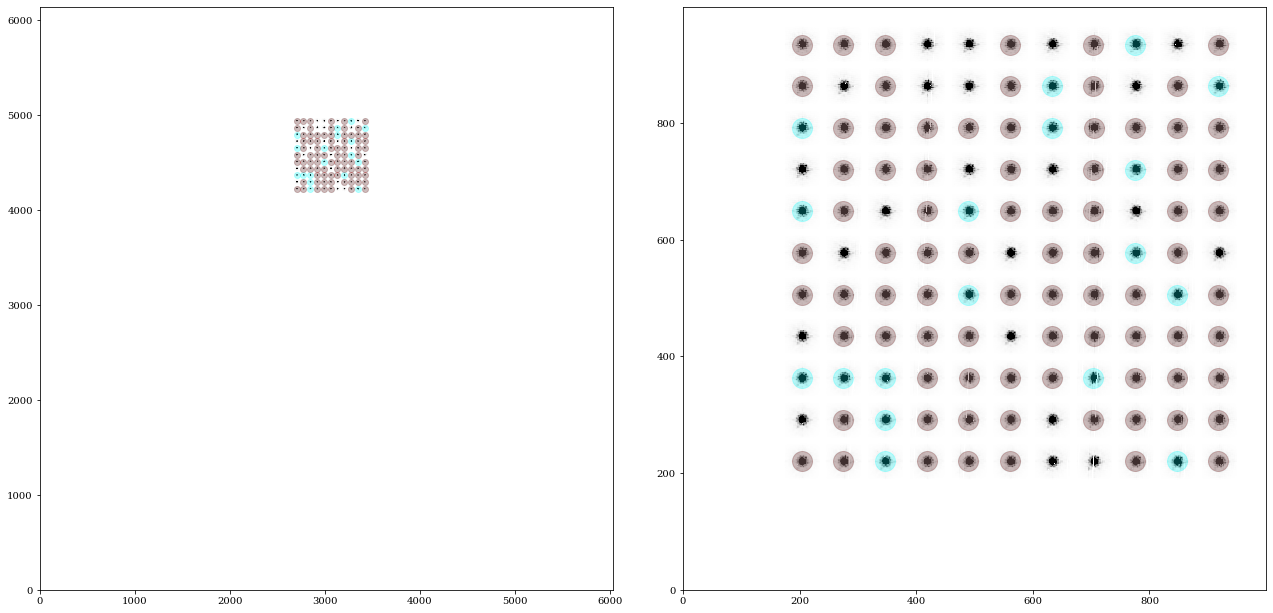

In [8]:
# (OPTIONAL) Display the image 

if 'fig1' in locals() or 'fig1' in globals(): plt.close(fig1)
fig1 = plt.figure(1,figsize=(18,9))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig1)

fig1_ax1 = fig1.add_axes([.05,.05,.5,.9]) #,projection=wcs)

fig1_ax1.imshow(data, origin = 'lower', vmin=data.min(), vmax = data.mean()*2, cmap = 'Greys')

if 'stars_tbl' in locals() or 'stars_tbl' in globals():
    fig1_ax1.plot(stars_tbl['xcentroid'],stars_tbl['ycentroid'],'o',alpha=0.25, color='cyan')
    fig1_ax1.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='red')
    fig1_ax2 = fig1.add_axes([.55,.05,.5,.9]) #,projection=wcs)
    fig1_ax2.imshow(data[4000:4000+1000,2500:2500+1000], origin = 'lower', vmin=data.min(), vmax = data.mean()*2, cmap = 'Greys')
    fig1_ax2.plot(stars_tbl['xcentroid']-2500,stars_tbl['ycentroid']-4000,'o',ms=20,alpha=0.25, color='cyan')
    fig1_ax2.plot(temp_tbl['xcentroid']-2500,temp_tbl['ycentroid']-4000,'o',ms=20,alpha=0.25, color='red')



In [4]:
# Find stars in the image

from photutils.detection import DAOStarFinder

# On the HLA image
dao_find = DAOStarFinder(threshold=50, fwhm=2.0, peakmax=9e4, sigma_radius=6, exclude_border=True, sharplo=0.6, sharphi=1.05, roundlo=-.1, roundhi=0.2) #, brightest=250)

# On the astrodrizzled
dao_find = DAOStarFinder(threshold=90, fwhm=2.2, peakmax=8e4, sigma_radius=7, exclude_border=True, sharplo=0.6, sharphi=1.1, roundlo=-.2, roundhi=0.25) #, brightest=250)

# On the astrodrizzled with tinytim PSFs
dao_find = DAOStarFinder(threshold=10, fwhm=2.8, peakmax=8e4, sigma_radius=5, exclude_border=True, sharplo=0.5, sharphi=1.1, roundlo=-.3, roundhi=0.3) #, brightest=250)


In [5]:
stars_tbl = dao_find(data)
print('Found {:} stars'.format(len(stars_tbl['id'])))
stars_tbl.sort('mag')

Found 99 stars


In [6]:
print('id     sharpness roundness1 roundness2\tpeak\tflux\tmag\n\
{:.5f} {:.5f} {:.5f} {:.5f} {:.5f} {:.5f}'.format(stars_tbl['id'][0],stars_tbl['sharpness'][0],stars_tbl['roundness1'][0],\
                                                         stars_tbl['roundness2'][0],stars_tbl['peak'][0],stars_tbl['flux'][0],stars_tbl['mag']))

id     sharpness roundness1 roundness2	peak	flux	mag
35.00000 0.72742 0.02216 0.07736 82.77425 19.35074


In [7]:
# Visualize in the above plot (in interactive only) the preselected stars

# Explicitly exclude stars that are too close to the image boundaries, because they cannot be extracted.

size = 50
hsize = (size - 1) / 2
x = stars_tbl['xcentroid']  
y = stars_tbl['ycentroid']  

# Filter by property
xcen=3800 ; ycen=2300
xcen=3100 ; ycen=4700
xcen=0 ; ycen=0
excl_radius = 1

round1=.3; round2=.3; sharp=0.7; mag_faint_inst = -0.0

mask = ((x > hsize) & (x < (data.shape[1] -1 - hsize)) & \
        (y > hsize) & (y < (data.shape[0] -1 - hsize)) & \
        (np.sqrt((x-xcen)**2 + (y-ycen)**2)>=excl_radius) & \
        (stars_tbl['mag']<=mag_faint_inst) & \
        (stars_tbl['sharpness']>=sharp) & \
        (abs(stars_tbl['roundness1'])<=round1) & \
        (abs(stars_tbl['roundness2'])<=round2))
    
temp_tbl = stars_tbl[mask].copy()

print('Selected {:} stars out of {:} initially detected'.format(len(temp_tbl['id']),len(stars_tbl['id'])))

fig1_ax1.plot(stars_tbl['xcentroid'],stars_tbl['ycentroid'],'o',alpha=0.25, color='cyan')
fig1_ax1.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='red')

Selected 81 stars out of 99 initially detected


N good stars: 81
N bad: 0
Total 81


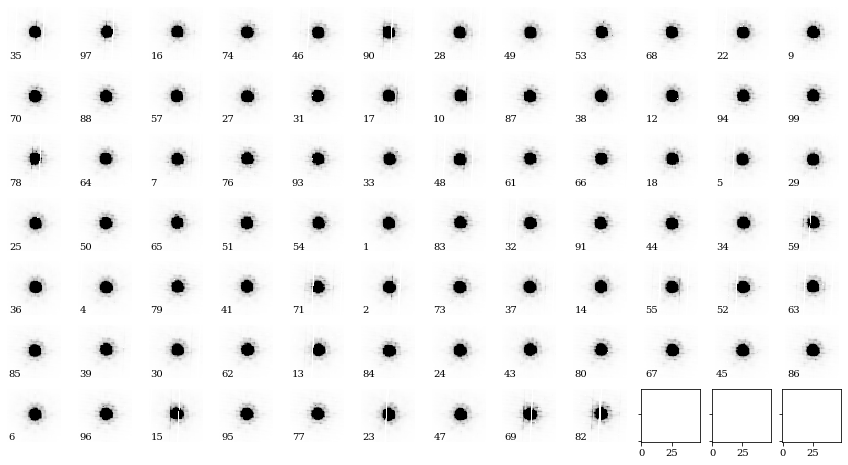

In [9]:
# Selecting EPSFStars, from which we’ll build our ePSF
from astropy.stats import sigma_clipped_stats

# Choose which stars to treat as good, if the sigma clipped stats of the star box are within mean_median_factor. Large factor does not exclude stars, e.g. 1e3.
# 
mean_median_factor = 1.3e3 # 1e3 # 

i=0
good_list_count = []
good_list = []
bad_list = []
# Needed in order to locate the index of a column
temp_tbl.add_index('id')

for epsf_star in temp_tbl:
    epsf_star_data = data[int(epsf_star['ycentroid']-hsize):int(epsf_star['ycentroid']+hsize),int(epsf_star['xcentroid']-hsize):int(epsf_star['xcentroid']+hsize)].copy()
    mean, median, std = sigma_clipped_stats(epsf_star_data, sigma=3.0)
    if std <= mean*mean_median_factor and std <= median*mean_median_factor:
        #print(epsf_star.id_label, mean, median, std,epsf_star.data.min())
        good_list_count.append(i)
        good_list.append(int(epsf_star['id']))
#        print(epsf_star['id'],median,epsf_star_data.min())
    else:
        bad_list.append(epsf_star['id'])
#        print(epsf_star['id'], end=', ')
#        temp_tbl.remove_row(temp_tbl.loc[int(epsf_star['id'])].index)
    i+=1
print('N good stars: {:}\nN bad: {:}\nTotal {:}'.format(len(good_list),len(bad_list),len(temp_tbl['id'])))

#from astropy.visualization import simple_norm
ncols = 12
if round(len(good_list_count)/ncols)<=2 :
    nrows = round(len(good_list_count)/ncols)
else:
    nrows = 7

#nrows = 5
if 'fig3' in globals(): plt.close(fig=fig3)
fig3, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True,figsize=(15,8),sharex=True, sharey=True)
fix_canvas(fig3)

good_list_upd = []
ax = ax.ravel()
for i,epsf_star in zip(range(len(good_list_count)),range(len(temp_tbl['id']))):
    epsf_star = temp_tbl[epsf_star]
    epsf_star_data = data[int(epsf_star['ycentroid']-hsize):int(epsf_star['ycentroid']+hsize),int(epsf_star['xcentroid']-hsize):int(epsf_star['xcentroid']+hsize)].copy()
    ax[i].imshow(epsf_star_data, vmin=epsf_star_data.min(), vmax=epsf_star_data.mean()*2, origin='lower', cmap='Greys') # norm=norm, 
    ax[i].text(1,1,'{:}'.format(epsf_star['id']))
    ax[i].axis('off')
    if int(epsf_star['id']) is not None:
        good_list_upd.append(int(epsf_star['id']))


In [10]:
print(good_list_upd, end=' ')

[35, 97, 16, 74, 46, 90, 28, 49, 53, 68, 22, 9, 70, 88, 57, 27, 31, 17, 10, 87, 38, 12, 94, 99, 78, 64, 7, 76, 93, 33, 48, 61, 66, 18, 5, 29, 25, 50, 65, 51, 54, 1, 83, 32, 91, 44, 34, 59, 36, 4, 79, 41, 71, 2, 73, 37, 14, 55, 52, 63, 85, 39, 30, 62, 13, 84, 24, 43, 80, 67, 45, 86, 6, 96, 15, 95, 77, 23, 47, 69, 82] 

In [ ]:
# Manually remove bad stars from the list above and re run the plot
# 

# On the HLA image
bad_list = [939,1138,755,1281,1208,1237,486,1025,1243,1173,1280,1166,12,475,1065,7,765,1290]
bad_list = [1223,1277,78,1303,18,864,914,1199,676,27,1265]
bad_list = [726,1227,16,1305,1255,503]

bad_list = [910,458,1086,801] #,1139, 860,869,2,1077,3,

# On the astrodrizzled image

bad_list = [437, 478, 213, 444]

for star_id in bad_list:
    temp_tbl.remove_row(temp_tbl.loc[star_id].index) 


In [ ]:

# Background image subtraction can be also done with a smooth large aperture median filetring and subtraction


In [11]:
# The star cutouts from which we build the ePSF must be background subtracted. 

from photutils import make_source_mask
from photutils import Background2D, MedianBackground

print('Calculating sigma clipped stats for source detection and masking')
mask = make_source_mask(data, nsigma=3, npixels=3, dilate_size=11,)
mean, median, std = sigma_clipped_stats(data, sigma=3.0, mask=mask)

print((mean, median, std)) 
# Additional mask if needed
# mask = (data == 0)

Calculating sigma clipped stats for source detection and masking
(0.0033281273, 0.0017671979, 0.0038929987)


In [12]:
# Execute this only once per session.

print('Calculating 2D background estimate on a smoothed and subgrided sections of the image')
bkg = Background2D(data, (55, 55), filter_size=(3, 3)) #, mask=mask)

# Applying the mask to the returned background image
bkg_img = bkg.background * ~mask

Calculating 2D background estimate on a smoothed and subgrided sections of the image


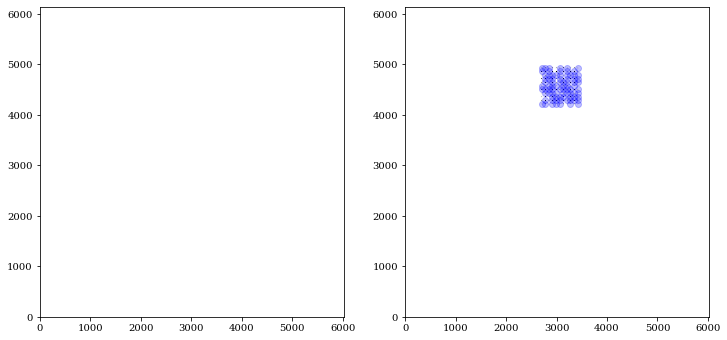

In [13]:
# (OPTIONAL) Display the background and the residual

if 'fig2' in globals() or 'fig2' in locals(): plt.close(fig2)
fig2 = plt.figure(2,figsize=(2*6,6))
# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig2)

fig2_ax1 = fig2.add_subplot(1,2,1) #, position=[.0,.1,.9,.9]) #,projection=wcs)
fig2_ax2 = fig2.add_subplot(1,2,2) #, position=[.25,.1,.9,.9]) #,projection=wcs)

fig2_ax1.imshow(bkg_img, origin = 'lower', vmin=0, vmax = bkg_img.max(), cmap = 'Greys')
fig2_ax2.imshow(data - bkg_img, origin = 'lower', vmin=0, vmax = (data - bkg_img).mean()*3, cmap = 'Greys')

# Overplot the preselected PSF stars
fig2_ax2.plot(temp_tbl['xcentroid'],temp_tbl['ycentroid'],'o',alpha=0.25, color='blue')

In [14]:
# Extracting the stars requires that the input table has column names x,y for the star's positions
# We're also saving the ePSF stars to a file

ePSF_stars_tbl = temp_tbl.copy()
ePSF_stars_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x','y'])
#ePSF_stars_tbl.write('{:}_ePSF_stars.dat'.format(filename), format='ascii', overwrite=True)

In [15]:
# The tinytim PSFs doesn't need background subtraction
bkg_img = bkg_img*0.0

In [16]:
# The extract_stars() function requires the input data as an NDData object. 
from astropy.nddata import NDData
nddata = NDData(data=(data-bkg_img))

# Extract the pixel cutouts of the selected stars:

from photutils.psf import extract_stars
ePSF_stars = extract_stars(nddata, ePSF_stars_tbl, size=50)


In [187]:
from photutils import EPSFBuilder,EPSFFitter
from photutils import centroids
from astropy.modeling.fitting import SLSQPLSQFitter,SimplexLSQFitter

#centroids.centroid_1dg # Calculate the centroid of a 2D array by fitting 1D Gaussians to the marginal x and y distributions of the array.
#centroids.centroid_2dg # Calculate the centroid of a 2D array by fitting a 2D Gaussian (plus a constant) to the array.
#centroids.centroid_com # Calculate the centroid of an n-dimensional array as its “center of mass” determined from moments.
#centroids.centroid_epsf # Calculates centering shift of data using pixel symmetry, as described by Anderson and King (2000; PASP 112, 1360) in their ePSF-fitting algorithm.
#centroids.centroid_sources # Calculate the centroid of sources at the defined positions.
#centroids.fit_2dgaussian # Fit a 2D Gaussian plus a constant to a 2D image.
#centroids.gaussian1d_moments # Estimate 1D Gaussian parameters from the moments of 1D data.

new_fitter = EPSFFitter(fit_boxsize=40.5) #,fitter=SLSQPLSQFitter())

epsf_builder = EPSFBuilder(oversampling=2, maxiters=2, recentering_maxiters=20, recentering_func=centroids.centroid_com, \
                           shift_val=0.1, fitter=new_fitter, progress_bar=True,smoothing_kernel='quartic', norm_radius=40.5,\
                           recentering_boxsize=(2.5, 2.5))

# Modify the clipping values
epsf_builder.sigma=4.0
epsf_builder.sigma_lower=4.
epsf_builder.sigma_upper=4.

epsf, fitted_stars = epsf_builder(ePSF_stars)
epsf.data.max()

0.07000604396983454

In [188]:
from astropy.modeling import models, fitting

epsf_x,epsf_y=np.mgrid[:np.shape(epsf.data)[0],:np.shape(epsf.data)[1]]

g_init = models.Gaussian2D(amplitude=epsf.data.max(),x_mean=epsf.x_origin,y_mean=epsf.y_origin,x_stddev=3.0,y_stddev=3.0, theta=.01,fixed={'x_stddev':True,'y_stddev':True})
fit_g = fitting.LevMarLSQFitter()
g2d = fit_g(g_init, x=epsf_x, y=epsf_y, z=epsf.data)

mof_init = models.Moffat2D(amplitude=epsf.data.max(),x_0=epsf.x_origin,y_0=epsf.y_origin,alpha=3.5,gamma=-6.) #,bounds={'gamma': (-10,10)},fixed={'alpha':True})
fit_mof = fitting.LevMarLSQFitter()
mof2d = fit_mof(mof_init, x=epsf_x, y=epsf_y, z=epsf.data)

# Composite
g_m_init = models.Gaussian2D(amplitude=g2d.amplitude.value/5,x_mean=g2d.x_mean.value,y_mean=g2d.y_mean.value,x_stddev=g2d.x_stddev.value,\
                             y_stddev=g2d.y_stddev.value, theta=g2d.theta.value) + \
models.Moffat2D(amplitude=mof2d.amplitude.value/1.,x_0=mof2d.x_0.value,y_0=mof2d.y_0.value,alpha=mof2d.alpha.value,gamma=mof2d.gamma.value)

fit_g_m = fitting.LevMarLSQFitter()
g_m_2d = fit_g_m(g_m_init, x=epsf_x, y=epsf_y, z=epsf.data)

In [189]:
g2d,mof2d,g_m_2d

(<Gaussian2D(amplitude=0.05903306, x_mean=54.05366616, y_mean=54.07582488, x_stddev=3., y_stddev=3., theta=0.01)>,
 <Moffat2D(amplitude=0.05035284, x_0=54.05285035, y_0=54.08585673, gamma=-15.5016913, alpha=13.31232867)>,
 <CompoundModel(amplitude_0=0.04697656, x_mean_0=54.09951561, y_mean_0=53.89512093, x_stddev_0=1.89126203, y_stddev_0=1.98104049, theta_0=30889012.73786709, amplitude_1=0.0265695, x_0_1=53.98620291, y_0_1=54.33371236, gamma_1=-14.77495147, alpha_1=8.57212231)>)

(-5.1000000000000005, 107.1, -5.1000000000000005, 107.1)

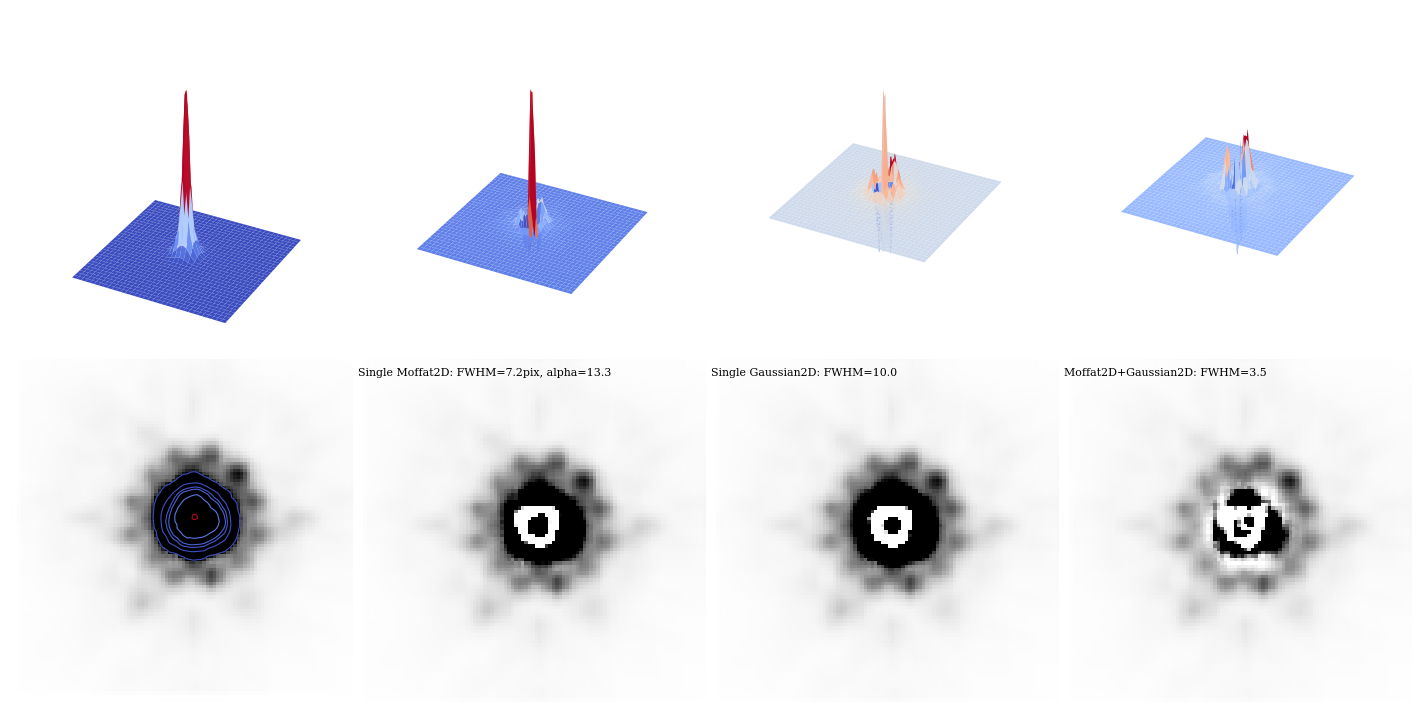

In [190]:
# Create a mesh plot from a selected region around the target

# Needed for the 3D mesh plot
from mpl_toolkits.mplot3d import Axes3D

# Create the meshgrid in x,y needed for the 3D
ny , nx = epsf.data.shape
x = np.arange(0,nx,1)
y = np.arange(0,ny,1)
xv, yv = np.meshgrid(x,y)

if 'fig4' in locals() or 'fig4' in globals(): plt.close(fig4)
fig4 = plt.figure(4,figsize=(9.8,9.8))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig4)

#fig4_ax = fig4.add_axes([.05,.05,.9,.9])
fig4_ax1 = fig4.add_subplot(4,2,1, position=[.01,.01,.5,.5])
fig4_ax2 = fig4.add_subplot(4,2,2, projection='3d', position=[.01,.5,.5,.5])
fig4_ax3 = fig4.add_subplot(4,2,3, projection='3d', position=[.5,.5,.5,.5])
fig4_ax4 = fig4.add_subplot(4,2,4, position=[.5,.0,.5,.5])
fig4_ax5 = fig4.add_subplot(4,2,5, position=[1.0,.0,.5,.5])
fig4_ax6 = fig4.add_subplot(4,2,6, projection='3d', position=[1.0,.5,.5,.5])
fig4_ax7 = fig4.add_subplot(4,2,7, position=[1.5,.0,.5,.5])
fig4_ax8 = fig4.add_subplot(4,2,8, projection='3d', position=[1.5,.5,.5,.5])

fig4_ax1.imshow(epsf.data, origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax1.contour(epsf.data, levels=[epsf.data.mean()*1.,epsf.data.mean()*3.5,epsf.data.mean()*7.,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.max()*.95], linewidths=1.1, cmap='coolwarm')
fig4_ax1.axis('off')

fig4_ax2.plot_surface(xv,yv,epsf.data, cmap='coolwarm',rcount=50,ccount=50)
fig4_ax2.view_init(elev=30, azim=208)
#fig4_ax2.contour(xv,yv,epsf.data, zdir='z', offset=epsf.data.max()*1.2, \
#                 levels=[epsf.data.mean()*2.,epsf.data.mean()*3.5,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
#                 cmap='coolwarm')
fig4_ax2.axis('off')

fig4_ax3.plot_surface(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax3.view_init(elev=30, azim=208)
#fig4_ax3.contour(xv,yv,epsf.data-mof2d(epsf_x,epsf_y), zdir='z', offset=(epsf.data-mof2d(epsf_x,epsf_y)).min()*1.2, \
#                 levels=[epsf.data.mean()*2.0,epsf.data.mean()*3.5,epsf.data.mean()*10,epsf.data.mean()*20,epsf.data.mean()*50,epsf.data.max()*.95], \
#                 cmap='coolwarm')
fig4_ax3.axis('off')

#fig4_ax3.imshow(epsf.data-g2d(epsf_x,epsf_y), origin='lower',vmin=0,vmax=(epsf.data-g2d(epsf_x,epsf_y)).mean()*5, cmap='Greys',\
#                label='Gaussian fit: $\sigma_x$={:.1f}, $\sigma_y$={:.1f}'.format(g2d.x_stddev.value, g2d.y_stddev.value))
fig4_ax4.imshow(epsf.data-mof2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax4.text(1,epsf.data.shape[0]*.95,'Single Moffat2D: FWHM={:.1f}pix, alpha={:.1f}'.format(mof2d.fwhm,mof2d.alpha.value),size=11)
fig4_ax4.axis('off')

fig4_ax5.imshow(epsf.data-g2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax5.text(1,epsf.data.shape[0]*.95,'Single Gaussian2D: FWHM={:.1f}'.format(np.sqrt(g2d.x_fwhm**2+g2d.y_fwhm**2)),size=11)
fig4_ax5.axis('off')

fig4_ax6.plot_surface(xv,yv,epsf.data-g2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax6.view_init(elev=30, azim=208)
fig4_ax6.axis('off')

fig4_ax7.imshow(epsf.data-g_m_2d(epsf_x,epsf_y), origin='lower',vmin=-0,vmax=epsf.data.mean(), cmap='Greys')
fig4_ax7.text(1,epsf.data.shape[0]*.95,'Moffat2D+Gaussian2D: FWHM={:.1f}'.format(np.sqrt(g_m_2d.x_stddev_0**2+g2d.y_stddev**2)),size=11)
fig4_ax7.axis('off')

fig4_ax8.plot_surface(xv,yv,epsf.data-g_m_2d(epsf_x,epsf_y), cmap='coolwarm',rcount=50,ccount=50)
fig4_ax8.view_init(elev=30, azim=208)
fig4_ax8.axis('off')

In [173]:
# (Optional) Save the figure 
fig_file_name = '{:s}.pdf'.format(filename)
fig4.savefig(fig_file_name,\
            format='pdf',transparent=True,dpi=120,bbox_inches='tight')
print('Saved figure {:s}'.format(fig_file_name))
os.system('pdfcrop {:} {:}'.format(fig_file_name,fig_file_name))
os.system('open {:}'.format(fig_file_name))

Saved figure NGC-2337_ACS_WFC_F814W_adrz_tPSF.pdf


0

In [193]:
# Save the ePSF as a fits file

tPSF_file_name = '{:s}_tPSFx{:}.fits'.format(filename,epsf_builder.oversampling[0])

fits.writeto(tPSF_file_name,data=epsf.data,overwrite=True)

In [175]:
# Store information in the header about the ePSF builder parameters used to generate the ePSF

#i=0
with fits.open(tPSF_file_name, 'update') as f:
    for hdu in f:
        hdu.header['Comment'] = 'tPSF for {:}'.format(filename)
        hdu.header['Comment'] = 'epsf_builder parameters:'
        for param in epsf_builder.__dict__:
            line1 = str(param).strip('_,:,>,<')
            line2 = str(epsf_builder.__dict__[param]).strip(r'],[_,:,>,<,\n')
#            print(line1,line2.split())
            hdu.header['Comment']=('{:} / {:}'.format(line1,line2.split()))
#        for star_xy in fitted_stars.center_flat:
#            hdu.header['Star{:}'.format(i)]=('{:}'.format(str(star_xy)),'epsf_builder star')
#            i+=1

In [176]:
# (Optional) Have a look at the header

print(repr(fits.getheader(tPSF_file_name)))

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                  103                                                  
NAXIS2  =                  103                                                  
EXTEND  =                    T                                                  
COMMENT tPSF for NGC-2337_ACS_WFC_F814W_adrz_tPSF                               
COMMENT epsf_builder parameters:                                                
COMMENT norm_radius / ['40.5']                                                  
COMMENT shift_val / ['0.1']                                                     
COMMENT oversampling / ['2', '2']                                               
COMMENT shape / ['None']                                                        
COMMENT recentering_func / [

# Perform basic PSF fitting photometry on the ePSF stars

In [177]:
from photutils.psf import (IterativelySubtractedPSFPhotometry,
                           BasicPSFPhotometry)
from photutils import MMMBackground
from photutils.psf import IntegratedGaussianPRF, DAOGroup
#from photutils.detection import DAOStarFinder
from astropy.table import Table
from astropy.modeling.fitting import LevMarLSQFitter



daogroup = DAOGroup(crit_separation=8)
mmm_bkg = MMMBackground()

fitter = LevMarLSQFitter()
#gaussian_prf = IntegratedGaussianPRF(sigma=1.95)
#gaussian_prf.sigma.fixed = False
ePSF_model = epsf
#itr_phot_obj = IterativelySubtractedPSFPhotometry(aperture_radius=5,
#                                                  finder=dao_find,
#                                                  group_maker=daogroup,
#                                                  bkg_estimator=mmm_bkg,
#                                                  psf_model=ePSF_model,
#                                                  fitter=fitter,
#                                                  fitshape=(11, 11),
#                                                  niters=2)

phot_obj = BasicPSFPhotometry(aperture_radius=5,
                              finder=None,
                              group_maker=daogroup,
                              bkg_estimator=mmm_bkg,
                              psf_model=ePSF_model,
                              fitter=fitter,
                              fitshape=(25, 25))

In [178]:
# Performing PSF photometry on a specific list of objects from a table, requires a bit table modification.
# It must contain sequenced stellar IDs and column names x_0,y_0

# Use the ePSF_stars_tbl 

phot_obj_tbl = Table(ePSF_stars_tbl,copy=True,copy_indices=False)
phot_obj_tbl.rename_columns(['x', 'y'], ['x_0','y_0'])

for i in range(1,len(phot_obj_tbl['id'])+1):
    phot_obj_tbl['id'][i-1]=i


In [179]:
# BasicPSFPhotometry on the list of ePSF stars

# Uncomment the lines below to use the DAOStarFinder table as an input
#
#phot_obj_tbl = stars_tbl.copy()
#if 'x_0' not in phot_obj_tbl.colnames and 'y_0' not in phot_obj_tbl.colnames :
#    phot_obj_tbl.rename_columns(['xcentroid', 'ycentroid'], ['x_0','y_0'])

phot_results = phot_obj(data,init_guesses=phot_obj_tbl)

In [180]:
phot_results.columns
#itr_phot_results.columns

<TableColumns names=('id','x_0','y_0','sharpness','roundness1','roundness2','npix','sky','peak','flux','mag','flux_0','group_id','x_fit','y_fit','flux_fit','flux_unc','x_0_unc','y_0_unc')>

In [181]:
#phot_results.columns
phot_results_rsd_img = phot_obj.get_residual_image()

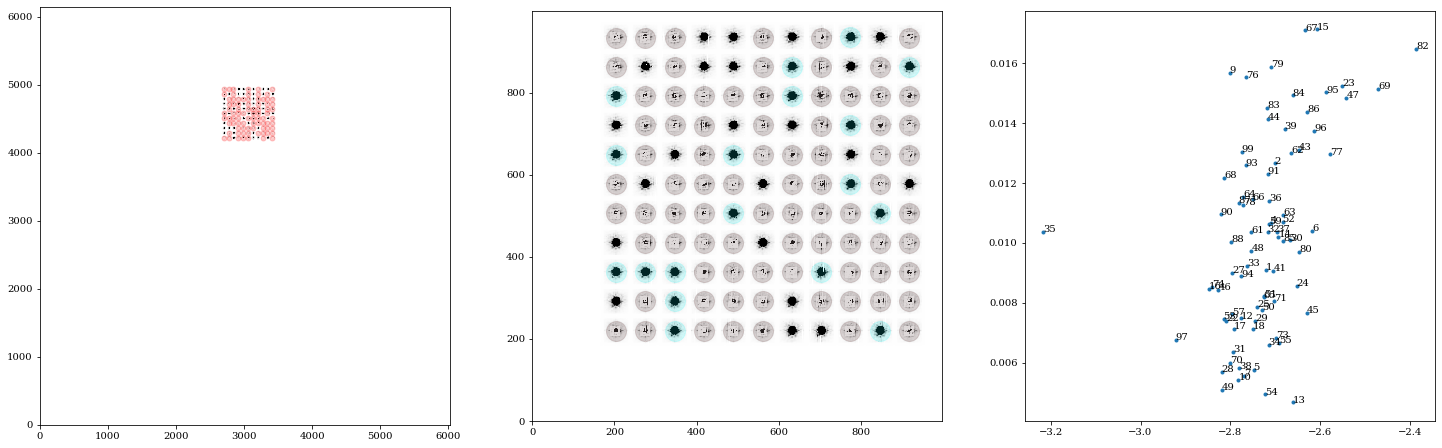

In [182]:
# Have a look at the residuals

if 'fig5' in locals() or 'fig5' in globals(): plt.close(fig5)
fig5 = plt.figure(5,figsize=(25,9))

# Needed to ensure that the figure canvas is properly set. It may be messed up in a jupyter lab notebook
fix_canvas(fig5)

fig5_ax1 = fig5.add_subplot(131)
fig5_ax2 = fig5.add_subplot(133)
fig5_ax3 = fig5.add_subplot(132)

fig5_ax1.imshow(phot_results_rsd_img, origin='lower', cmap='Greys', vmin=phot_results_rsd_img.mean()*.05, vmax=phot_results_rsd_img.mean()*1.5)
fig5_ax1.plot(phot_results['x_fit'],phot_results['y_fit'],'o',ms=5,color='red', alpha=.2)

fig5_ax3.imshow(phot_results_rsd_img[4000:4000+1000,2500:2500+1000], origin = 'lower', vmin=0, vmax = phot_results_rsd_img.mean()*2, cmap = 'Greys')
fig5_ax3.plot(stars_tbl['xcentroid']-2500,stars_tbl['ycentroid']-4000,'o',ms=20,alpha=0.15, color='cyan')
fig5_ax3.plot(temp_tbl['xcentroid']-2500,temp_tbl['ycentroid']-4000,'o',ms=20,alpha=0.15, color='red')

selection = (phot_results['x_0']==stars_tbl['xcentroid']) & (phot_results['y_0']==stars_tbl['ycentroid'])
#selection = (phot_results['x_fitt']==ePSF_stars_tbl['x']) & (phot_results['y_fit']==ePSF_stars_tbl['y'])
fig5_ax2.plot(phot_results['mag'],2.5*phot_results['flux_unc']/(np.log(10)*(phot_results['flux_fit'])),'.')
for x_text,y_text,label_text in zip(phot_results['mag'],\
                                    2.5*phot_results['flux_unc']/(np.log(10)*(phot_results['flux_fit'])),\
                                    temp_tbl['id'][phot_results['x_0']==temp_tbl['xcentroid']]):
    fig5_ax2.text(x_text,y_text,label_text)
aspect_squared = (max(fig5_ax2.get_xlim())-min(fig5_ax2.get_xlim()))/(max(fig5_ax2.get_ylim())-min(fig5_ax2.get_ylim()))
fig5_ax2.set_aspect(aspect_squared)


ID	Median	std	Min	Max
35	-0.05	2.14	-20.99	25.05
97	-0.02	1.12	-6.78	12.14
16	-0.01	1.27	-10.71	14.16
74	-0.00	1.24	-13.79	14.74
46	-0.01	1.28	-13.62	16.71
90	0.00	1.57	-15.67	19.93
28	-0.01	0.86	-6.50	9.26
49	-0.01	0.76	-6.71	11.52
53	-0.01	1.11	-8.40	12.94
68	-0.00	1.77	-19.78	27.72
22	-0.00	1.08	-11.36	11.55
9	-0.00	2.25	-23.55	32.70
70	-0.00	0.85	-7.34	7.32
88	-0.00	1.45	-12.50	20.78


/Users/georgiev/Installs/miniconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:745: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


57	-0.00	1.09	-10.70	11.86
27	-0.00	1.31	-13.15	20.35
31	-0.01	0.93	-9.96	12.37
17	0.00	1.03	-11.35	9.23
10	-0.00	0.77	-5.11	10.20
87	-0.00	1.63	-13.90	21.86
38	0.00	0.81	-7.60	6.66
12	0.00	1.05	-10.41	10.31
94	-0.00	1.24	-12.94	16.39
99	-0.00	1.81	-21.69	21.71
78	-0.00	1.66	-17.86	16.60
64	-0.01	1.72	-18.23	28.32
7	0.00	0.79	-7.24	8.56
76	-0.00	2.16	-21.32	26.91
93	-0.00	1.77	-19.44	22.55
33	-0.00	1.32	-13.70	20.94
48	-0.00	1.42	-16.33	19.12
61	-0.00	1.47	-14.81	18.85
66	-0.00	1.65	-18.38	22.75
18	0.00	0.98	-11.69	8.77
5	-0.00	0.84	-7.29	8.34
29	0.00	1.04	-12.82	10.01
25	0.00	1.10	-11.14	12.34
50	0.00	1.07	-9.56	11.02
65	0.00	1.13	-10.04	14.63
51	0.00	1.13	-12.43	16.28
54	0.00	0.68	-5.19	8.32
1	0.00	1.24	-12.74	18.35
83	0.00	1.95	-23.53	21.24
32	0.00	1.41	-16.39	14.27
91	0.00	1.69	-17.74	24.85
44	0.00	1.96	-18.76	30.29
34	0.00	0.89	-8.33	7.34
59	0.00	1.43	-15.66	13.36
36	0.00	1.53	-17.70	17.52
4	0.00	1.44	-16.78	14.35
79	-0.00	2.19	-20.22	30.66
41	0.00	1.24	-15.35	14.49
71	0.01	1.09	-

IndexError: index 72 is out of bounds for axis 0 with size 72

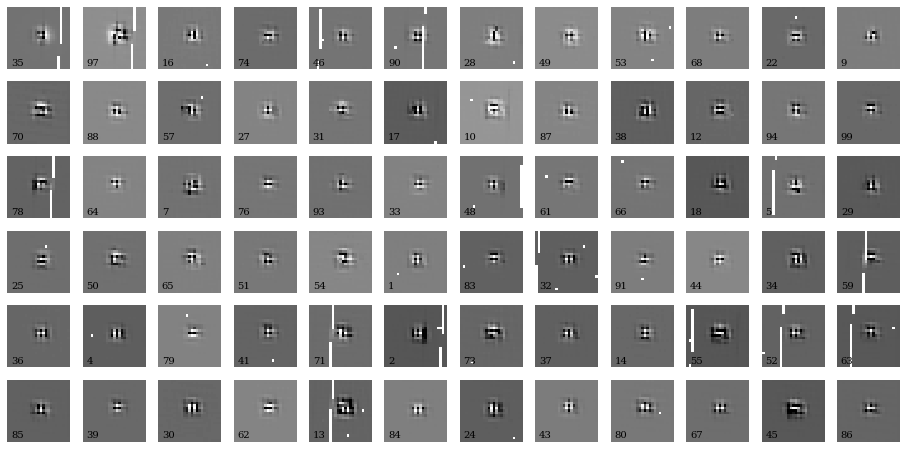

In [183]:
# 
width = 25
ncols = 12
if round(len(good_list_count)/ncols)<=2 :
    nrows = round(len(good_list_count)/ncols)
else:
    nrows = 6

if 'fig6' in globals(): plt.close(fig=fig6)
fig6, ax = plt.subplots(nrows=nrows, ncols=ncols, squeeze=True,figsize=(16,8),sharex=True, sharey=True)
fix_canvas(fig6)

ax = ax.ravel()
print('ID\tMedian\tstd\tMin\tMax')
for i,epsf_star in zip(range(len(good_list_count)),range(len(ePSF_stars_tbl['id']))):
    epsf_star = ePSF_stars_tbl[epsf_star]
    epsf_star_data = phot_results_rsd_img[int(epsf_star['y']-width/2):int(epsf_star['y']+width/2),int(epsf_star['x']-width/2):int(epsf_star['x']+width/2)].copy()
    ax[i].imshow(epsf_star_data, vmin=epsf_star_data.min(), vmax=epsf_star_data.max()*.5, origin='lower', cmap='Greys') # norm=norm, 
    ax[i].text(1,1,'{:}'.format(epsf_star['id']))
    ax[i].axis('off')
    print('{:}\t{:.2f}\t{:.2f}\t{:.2f}\t{:.2f}'.format(epsf_star['id'],np.median(epsf_star_data),epsf_star_data.std(),epsf_star_data.min(),epsf_star_data.max()))


In [184]:
# Based on the residuals above, one can further remove sources that show strong, non stellar like residuals or have contaminants
# Then rerun 


In [185]:
print(good_list_upd, end=' ')

[35, 97, 16, 74, 46, 90, 28, 49, 53, 68, 22, 9, 70, 88, 57, 27, 31, 17, 10, 87, 38, 12, 94, 99, 78, 64, 7, 76, 93, 33, 48, 61, 66, 18, 5, 29, 25, 50, 65, 51, 54, 1, 83, 32, 91, 44, 34, 59, 36, 4, 79, 41, 71, 2, 73, 37, 14, 55, 52, 63, 85, 39, 30, 62, 13, 84, 24, 43, 80, 67, 45, 86, 6, 96, 15, 95, 77, 23, 47, 69, 82] 

In [186]:
#temp_tbl[temp_tbl['id']==339]
phot_results[(phot_results['x_0']==temp_tbl['xcentroid'][temp_tbl['id']==13]) | (phot_results['x_0']==temp_tbl['xcentroid'][temp_tbl['id']==59])]

id,x_0,y_0,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,flux_0,group_id,x_fit,y_fit,flux_fit,flux_unc,x_0_unc,y_0_unc
int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,float64
48,2918.2213122820467,4648.3317255953425,0.9675565949062398,0.10054526673746104,0.18541913164835394,121,0.0,67.63587951660156,12.17492468501301,-2.7136657082927735,751.4702213381777,48,2916.6864386657726,4646.932772730859,918.6192421623632,8.999564692989278,0.018684645451252195,0.018463975737519775
65,2989.325941860294,4291.126049502478,0.8081852499355304,0.024752327325979148,-0.0427780106507638,121,0.0,55.69322204589844,11.603574535430472,-2.661479490713,798.9589251667344,65,2987.7962337250187,4289.620625457064,902.9942726645849,3.8850461649005457,0.0081335472500375,0.007917277513351487


In [194]:
get_ipython()

In [197]:
get_ipython()